# Image segmentation with SwinUNET

In [ ]:
!git clone https://github.com/yingkaisha/keras-vision-transformer.git

Cloning into 'keras-vision-transformer'...
remote: Enumerating objects: 95, done.
remote: Counting objects: 100% (95/95), done.
remote: Compressing objects: 100% (80/80), done.
remote: Total 95 (delta 45), reused 35 (delta 12), pack-reused 0
Unpacking objects: 100% (95/95), 155.59 KiB | 1.60 MiB/s, done.


In [ ]:
import numpy as np
from glob import glob
import cv2
import tensorflow as tf
from tensorflow import keras

In [ ]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Conv2D, concatenate

In [ ]:
import sys
sys.path.append('../')

from keras_vision_transformer import swin_layers
from keras_vision_transformer import transformer_layers
from keras_vision_transformer import utils

# Data

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
import zipfile
zip_file = zipfile.ZipFile('/content/gdrive/MyDrive/Glaucoma_lengkap.zip', 'r')
zip_file.extractall('/content/')

In [ ]:
# the indicator of a fresh run
first_time_running = False

# user-specified working directory
# filepath = '/content/oxford_iiit'
filepath = '/tmp/TrainData'

# The Swin-UNET

Two functions are provided for customizing the Swin-UNET:
    
* `swin_transformer_stack`: a function that stacks multiple Swin Transformers.
* `swin_unet_2d_base`: the base architecture of the Swin-UNET with down-/upsampling levels and skip connections.

In [ ]:
def swin_transformer_stack(X, stack_num, embed_dim, num_patch, num_heads, window_size, num_mlp, shift_window=True, name=''):
    '''
    Stacked Swin Transformers that share the same token size.

    Alternated Window-MSA and Swin-MSA will be configured if `shift_window=True`, Window-MSA only otherwise.
    *Dropout is turned off.
    '''
    # Turn-off dropouts
    mlp_drop_rate = 0 # Droupout after each MLP layer
    attn_drop_rate = 0 # Dropout after Swin-Attention
    proj_drop_rate = 0 # Dropout at the end of each Swin-Attention block, i.e., after linear projections
    drop_path_rate = 0 # Drop-path within skip-connections

    qkv_bias = True # Convert embedded patches to query, key, and values with a learnable additive value
    qk_scale = None # None: Re-scale query based on embed dimensions per attention head # Float for user specified scaling factor

    if shift_window:
        shift_size = window_size // 2
    else:
        shift_size = 0

    for i in range(stack_num):

        if i % 2 == 0:
            shift_size_temp = 0
        else:
            shift_size_temp = shift_size

        X = swin_layers.SwinTransformerBlock(dim=embed_dim,
                                             num_patch=num_patch,
                                             num_heads=num_heads,
                                             window_size=window_size,
                                             shift_size=shift_size_temp,
                                             num_mlp=num_mlp,
                                             qkv_bias=qkv_bias,
                                             qk_scale=qk_scale,
                                             mlp_drop=mlp_drop_rate,
                                             attn_drop=attn_drop_rate,
                                             proj_drop=proj_drop_rate,
                                             drop_path_prob=drop_path_rate,
                                             name='name{}'.format(i))(X)
    return X


def swin_unet_2d_base(input_tensor, filter_num_begin, depth, stack_num_down, stack_num_up,
                      patch_size, num_heads, window_size, num_mlp, shift_window=True, name='swin_unet'):
    '''
    The base of Swin-UNET.

    The general structure:

    1. Input image --> a sequence of patches --> tokenize these patches
    2. Downsampling: swin-transformer --> patch merging (pooling)
    3. Upsampling: concatenate --> swin-transfprmer --> patch expanding (unpooling)
    4. Model head

    '''
    # Compute number be patches to be embeded
    input_size = input_tensor.shape.as_list()[1:]
    num_patch_x = input_size[0]//patch_size[0]
    num_patch_y = input_size[1]//patch_size[1]

    # Number of Embedded dimensions
    embed_dim = filter_num_begin

    depth_ = depth

    X_skip = []

    X = input_tensor

    # Patch extraction
    X = transformer_layers.patch_extract(patch_size)(X)

    # Embed patches to tokens
    X = transformer_layers.patch_embedding(num_patch_x*num_patch_y, embed_dim)(X)

    # The first Swin Transformer stack
    X = swin_transformer_stack(X,
                               stack_num=stack_num_down,
                               embed_dim=embed_dim,
                               num_patch=(num_patch_x, num_patch_y),
                               num_heads=num_heads[0],
                               window_size=window_size[0],
                               num_mlp=num_mlp,
                               shift_window=shift_window,
                               name='{}_swin_down0'.format(name))
    X_skip.append(X)

    # Downsampling blocks
    for i in range(depth_-1):

        # Patch merging
        X = transformer_layers.patch_merging((num_patch_x, num_patch_y), embed_dim=embed_dim, name='down{}'.format(i))(X)

        # update token shape info
        embed_dim = embed_dim*2
        num_patch_x = num_patch_x//2
        num_patch_y = num_patch_y//2

        # Swin Transformer stacks
        X = swin_transformer_stack(X,
                                   stack_num=stack_num_down,
                                   embed_dim=embed_dim,
                                   num_patch=(num_patch_x, num_patch_y),
                                   num_heads=num_heads[i+1],
                                   window_size=window_size[i+1],
                                   num_mlp=num_mlp,
                                   shift_window=shift_window,
                                   name='{}_swin_down{}'.format(name, i+1))

        # Store tensors for concat
        X_skip.append(X)

    # reverse indexing encoded tensors and hyperparams
    X_skip = X_skip[::-1]
    num_heads = num_heads[::-1]
    window_size = window_size[::-1]

    # upsampling begins at the deepest available tensor
    X = X_skip[0]

    # other tensors are preserved for concatenation
    X_decode = X_skip[1:]

    depth_decode = len(X_decode)

    for i in range(depth_decode):

        # Patch expanding
        X = transformer_layers.patch_expanding(num_patch=(num_patch_x, num_patch_y),
                                               embed_dim=embed_dim,
                                               upsample_rate=2,
                                               return_vector=True)(X)


        # update token shape info
        embed_dim = embed_dim//2
        num_patch_x = num_patch_x*2
        num_patch_y = num_patch_y*2

        # Concatenation and linear projection
        X = concatenate([X, X_decode[i]], axis=-1, name='{}_concat_{}'.format(name, i))
        X = Dense(embed_dim, use_bias=False, name='{}_concat_linear_proj_{}'.format(name, i))(X)

        # Swin Transformer stacks
        X = swin_transformer_stack(X,
                                   stack_num=stack_num_up,
                                   embed_dim=embed_dim,
                                   num_patch=(num_patch_x, num_patch_y),
                                   num_heads=num_heads[i],
                                   window_size=window_size[i],
                                   num_mlp=num_mlp,
                                   shift_window=shift_window,
                                   name='{}_swin_up{}'.format(name, i))

    # The last expanding layer; it produces full-size feature maps based on the patch size
    # !!! <--- "patch_size[0]" is used; it assumes patch_size = (size, size)

    X = transformer_layers.patch_expanding(num_patch=(num_patch_x, num_patch_y),
                                           embed_dim=embed_dim,
                                           upsample_rate=patch_size[0],
                                           return_vector=False)(X)

    return X

## Hyperparameters

Hyperparameters of the Swin-UNET are listed as follows:

In [ ]:
filter_num_begin = 192   # number of channels in the first downsampling block; it is also the number of embedded dimensions
depth = 4                  # the depth of SwinUNET; depth=4 means three down/upsampling levels and a bottom level
stack_num_down = 2         # number of Swin Transformers per downsampling level
stack_num_up = 2           # number of Swin Transformers per upsampling level
patch_size = (2,2)        # Extract 4-by-4 patches from the input image. Height and width of the patch must be equal.
num_heads = [3, 6, 12, 24]   # number of attention heads per down/upsampling level
window_size = [7, 7, 7, 7] # the size of attention window per down/upsampling level
num_mlp = 6144              # number of MLP nodes within the Transformer
shift_window=True          # Apply window shifting, i.e., Swin-MSA

## Model configuration

In [ ]:
#Input section
input_size = (224, 224, 3)
IN = Input(input_size)

# Base architecture
X = swin_unet_2d_base(IN, filter_num_begin, depth, stack_num_down, stack_num_up,
                      patch_size, num_heads, window_size, num_mlp,
                      shift_window=shift_window, name='swin_unet')

In [ ]:
# Output section
n_labels = 3
OUT = Conv2D(n_labels, kernel_size=1, use_bias=False, activation='softmax')(X)

# Model configuration
model = Model(inputs=[IN,], outputs=[OUT,])

In [ ]:
# Optimization
# <---- !!! gradient clipping is important
opt = keras.optimizers.Adam(learning_rate=1e-4, clipvalue=0.5)
model.compile(loss=keras.losses.categorical_crossentropy, optimizer=opt)

In [ ]:
def input_data_process(input_array):
    '''converting pixel vales to [0, 1]'''
    return input_array/255.

def target_data_process(target_array):
    '''Converting tri-mask of {1, 2, 3} to three categories.'''
    # if target_array.all() >=  255 :
    #    target_array = np.dot(target_array[...,0:3],[0.299, 0.587, 0.114])
    #    return keras.utils.to_categorical(target_array-1)
    # else :
    # return target_array
    return keras.utils.to_categorical((target_array))


In [ ]:
sample_names = np.array(sorted(glob('/content/image_campur/*.jpg')))
label_names = np.array(sorted(glob('/content/mask_campur/*.png')))

L = len(sample_names)
np.random.seed(212)
ind_all = utils.shuffle_ind(L)

L_train = int(0.8*L); L_valid = int(0.1*L); L_test = L - L_train - L_valid
ind_train = ind_all[:L_train]; ind_valid = ind_all[L_train:L_train+L_valid]; ind_test = ind_all[L_train+L_valid:]
print("Training:validation:testing = {}:{}:{}".format(L_train, L_valid, L_test))

Training:validation:testing = 960:120:120


In [ ]:
valid_input = input_data_process(utils.image_to_array(sample_names[ind_valid], size=224, channel=3))
valid_target = target_data_process(utils.image_to_array(label_names[ind_valid], size=224, channel=1))

In [ ]:
len(valid_target)

120

In [ ]:
test_input = input_data_process(utils.image_to_array(sample_names[ind_test], size=224, channel=3))
test_target = target_data_process(utils.image_to_array(label_names[ind_test], size=224, channel=1))

In [ ]:
%matplotlib inline

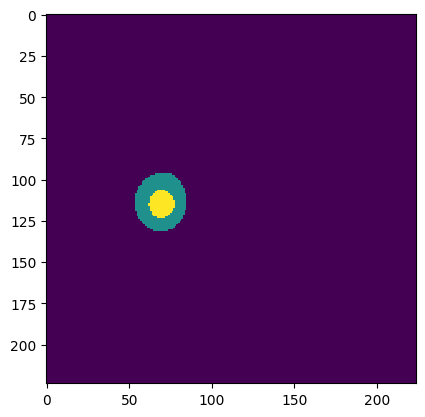

In [ ]:
from matplotlib import pyplot as plt
plt.imshow(sa[1], interpolation='nearest')
plt.show()

In [ ]:
test_input.shape

(120, 224, 224, 3)

In [ ]:
test_target.shape

(120, 224, 224, 3)

In [ ]:
valid_input.shape

(120, 224, 224, 3)

In [ ]:
valid_target.shape

(120, 224, 224, 3)

In [ ]:
N_epoch = 200 # number of epoches
N_batch = 32 # number of batches per epoch
N_sample = 16 # number of samples per batch

tol = 0 # current early stopping patience
max_tol = 10 # the max-allowed early stopping patience
min_del = 0 # the lowest acceptable loss value reduction

# loop over epoches
for epoch in range(N_epoch):

    # initial loss record
    if epoch == 0:
        y_pred = model.predict([valid_input])
        record = np.mean(keras.losses.categorical_crossentropy(valid_target, y_pred))
        print('\tInitial loss = {}'.format(record))

    # loop over batches
    for step in range(N_batch):
        # selecting smaples for the current batch
        ind_train_shuffle = utils.shuffle_ind(L_train)[:N_sample]

        # batch data formation
        ## augmentation is not applied
        train_input = input_data_process(
            utils.image_to_array(sample_names[ind_train][ind_train_shuffle], size=224, channel=3))
        train_target = target_data_process(
            utils.image_to_array(label_names[ind_train][ind_train_shuffle], size=224, channel=1))

        # train on batch
        loss_ = model.train_on_batch([train_input,], [train_target,])
#         if np.isnan(loss_):
#             print("Training blow-up")

        # ** training loss is not stored ** #

    # epoch-end validation
    y_pred = model.predict([valid_input])
    record_temp = np.mean(keras.losses.categorical_crossentropy(valid_target, y_pred))
    # ** validation loss is not stored ** #

    # if loss is reduced
    if record - record_temp > min_del:
        print('Validation performance is improved from {} to {}'.format(record, record_temp))
        record = record_temp; # update the loss record
        tol = 0; # refresh early stopping patience
        # ** model checkpoint is not stored ** #

    # if loss not reduced
    else:
        print('Validation performance {} is NOT improved'.format(record_temp))
        tol += 1
        if tol >= max_tol:
            print('Early stopping')
            break;
        else:
            # Pass to the next epoch
            continue;

In [ ]:
import numpy as np
import keras.backend as K
import tensorflow as tf

def metrics_np(y_true, y_pred, metric_name, metric_type='standard', drop_last = True, mean_per_class=False, verbose=False):
    """
    Compute mean metrics of two segmentation masks, via numpy.

    IoU(A,B) = |A & B| / (| A U B|)
    Dice(A,B) = 2*|A & B| / (|A| + |B|)

    Args:
        y_true: true masks, one-hot encoded.
        y_pred: predicted masks, either softmax outputs, or one-hot encoded.
        metric_name: metric to be computed, either 'iou' or 'dice'.
        metric_type: one of 'standard' (default), 'soft', 'naive'.
          In the standard version, y_pred is one-hot encoded and the mean
          is taken only over classes that are present (in y_true or y_pred).
          The 'soft' version of the metrics are computed without one-hot
          encoding y_pred.
          The 'naive' version return mean metrics where absent classes contribute
          to the class mean as 1.0 (instead of being dropped from the mean).
        drop_last = True: boolean flag to drop last class (usually reserved
          for background class in semantic segmentation)
        mean_per_class = False: return mean along batch axis for each class.
        verbose = False: print intermediate results such as intersection, union
          (as number of pixels).
    Returns:
        IoU/Dice of y_true and y_pred, as a float, unless mean_per_class == True
          in which case it returns the per-class metric, averaged over the batch.

    Inputs are B*W*H*N tensors, with
        B = batch size,
        W = width,
        H = height,
        N = number of classes
    """

    assert y_true.shape == y_pred.shape, 'Input masks should be same shape, instead are {}, {}'.format(y_true.shape, y_pred.shape)
    assert len(y_pred.shape) == 4, 'Inputs should be B*W*H*N tensors, instead have shape {}'.format(y_pred.shape)

    flag_soft = (metric_type == 'soft')
    flag_naive_mean = (metric_type == 'naive')

    num_classes = y_pred.shape[-1]
    # if only 1 class, there is no background class and it should never be dropped
    drop_last = drop_last and num_classes>1

    if not flag_soft:
        if num_classes>1:
            # get one-hot encoded masks from y_pred (true masks should already be in correct format, do it anyway)
            y_pred = np.array([ np.argmax(y_pred, axis=-1)==i for i in range(num_classes) ]).transpose(1,2,3,0)
            y_true = np.array([ np.argmax(y_true, axis=-1)==i for i in range(num_classes) ]).transpose(1,2,3,0)
        else:
            y_pred = (y_pred > 0).astype(int)
            y_true = (y_true > 0).astype(int)

    # intersection and union shapes are batch_size * n_classes (values = area in pixels)
    axes = (1,2) # W,H axes of each image
    intersection = np.sum(np.abs(y_pred * y_true), axis=axes) # or, np.logical_and(y_pred, y_true) for one-hot
    mask_sum = np.sum(np.abs(y_true), axis=axes) + np.sum(np.abs(y_pred), axis=axes)
    union = mask_sum  - intersection # or, np.logical_or(y_pred, y_true) for one-hot

    if verbose:
        print('intersection (pred*true), intersection (pred&true), union (pred+true-inters), union (pred|true)')
        print(intersection, np.sum(np.logical_and(y_pred, y_true), axis=axes), union, np.sum(np.logical_or(y_pred, y_true), axis=axes))

    smooth = .001
    iou = (intersection + smooth) / (union + smooth)
    dice = 2*(intersection + smooth)/(mask_sum + smooth)

    metric = {'iou': iou, 'dice': dice}[metric_name]

    # define mask to be 0 when no pixels are present in either y_true or y_pred, 1 otherwise
    mask =  np.not_equal(union, 0).astype(int)
    # mask = 1 - np.equal(union, 0).astype(int) # True = 1

    if drop_last:
        metric = metric[:,:-1]
        mask = mask[:,:-1]

    # return mean metrics: remaining axes are (batch, classes)
    # if mean_per_class, average over batch axis only
    # if flag_naive_mean, average over absent classes too
    if mean_per_class:
        if flag_naive_mean:
            return np.mean(metric, axis=0)
        else:
            # mean only over non-absent classes in batch (still return 1 if class absent for whole batch)
            return (np.sum(metric * mask, axis=0) + smooth)/(np.sum(mask, axis=0) + smooth)
    else:
        if flag_naive_mean:
            return np.mean(metric)
        else:
            # mean only over non-absent classes
            class_count = np.sum(mask, axis=0)
            return np.mean(np.sum(metric * mask, axis=0)[class_count!=0]/(class_count[class_count!=0]))

## Evaluation

The testing set performance is evaluated.

In [ ]:
# print('{:<60s} {:.3f}'.format('IoU of first class:', metrics_np(test_target[:,:,:,:1], y_pred[:,:,:,:1], metric_name='iou')))
# print('{:<60s} {:.3f}'.format('IoU of second class:', metrics_np(test_target[:,:,:,1:2], y_pred[:,:,:,1:2], metric_name='iou')))
# print('{:<60s} {:.3f}'.format('IoU of background:', metrics_np(test_target[:,:,:,-1:], y_pred[:,:,:,-1:], metric_name='iou')))
print('{:<60s} {}'.format('IoU of each class (explicit list):', metrics_np(valid_target, y_pred, metric_name='iou', metric_type='naive', drop_last=False, mean_per_class=True)))
# print('{:<60s} {:.3f}'.format('mean IoU of all classes (no background, naive mean):', metrics_np(test_target, y_pred, metric_name='iou', metric_type='naive')))
# print('{:<60s} {:.3f}'.format('mean IoU of all classes (with background, naive mean):', metrics_np(test_target, y_pred, metric_name='iou', metric_type='naive', drop_last = False)))
# print('{:<60s} {:.3f}'.format('mean IoU of all non-absent classes (dropping background):', metrics_np(test_target,ssssssssssssssssssssssssssssssss y_pred, metric_name='iou')))


In [ ]:
# print('{:<60s} {:.3f}'.format('IoU of first class:', metrics_np(test_target[:,:,:,:1], y_pred[:,:,:,:1], metric_name='iou')))
# print('{:<60s} {:.3f}'.format('IoU of second class:', metrics_np(test_target[:,:,:,1:2], y_pred[:,:,:,1:2], metric_name='iou')))
# print('{:<60s} {:.3f}'.format('IoU of background:', metrics_np(test_target[:,:,:,-1:], y_pred[:,:,:,-1:], metric_name='iou')))
print('{:<60s} {}'.format('IoU of each class (explicit list):', metrics_np(test_target, y_pred, metric_name='iou', metric_type='naive', drop_last=False, mean_per_class=True)))
# print('{:<60s} {:.3f}'.format('mean IoU of all classes (no background, naive mean):', metrics_np(test_target, y_pred, metric_name='iou', metric_type='naive')))
# print('{:<60s} {:.3f}'.format('mean IoU of all classes (with background, naive mean):', metrics_np(test_target, y_pred, metric_name='iou', metric_type='naive', drop_last = False)))
# print('{:<60s} {:.3f}'.format('mean IoU of all non-absent classes (dropping background):', metrics_np(test_target, y_pred, metric_name='iou')))


Iou Salah satu

In [ ]:

y_true = test_target[130]
y_pred = y_pred[130]  # they must be the same shape

In [ ]:
test_target

In [ ]:
y_true = y_true.reshape((1,)+y_true.shape)

In [ ]:
y_pred = y_pred.reshape((1,)+y_pred.shape)

In [ ]:
y_true.shape

In [ ]:
print('{:<60s} {}'.format('IoU of each class (explicit list):', metrics_np(y_true, y_pred, metric_name='iou', metric_type='naive', drop_last=False, mean_per_class=True)))

In [ ]:
y_pred = model.predict([test_input,])
print('Testing set cross-entropy loss = {}'.format(np.mean(keras.losses.categorical_crossentropy(test_target, y_pred))))

In [ ]:
import cv2
import os
import random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

**Example of outputs**

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:
def ax_decorate_box(ax):
    [j.set_linewidth(0) for j in ax.spines.values()]
    ax.tick_params(axis="both", which="both", bottom=False, top=False,
                   labelbottom=False, left=False, right=False, labelleft=False)
    return ax

In [ ]:
i_sample = 2

fig, AX = plt.subplots(1, 4, figsize=(13, (13-0.2)/4))
plt.subplots_adjust(0, 0, 1, 1, hspace=0, wspace=0.1)
for ax in AX:
    ax = ax_decorate_box(ax)
AX[0].pcolormesh(np.mean(test_input[i_sample, ...,], axis=-1), cmap=plt.cm.gray)
AX[1].pcolormesh(y_pred[i_sample, ..., 0], cmap=plt.cm.jet)
AX[2].pcolormesh(y_pred[i_sample, ..., 1], cmap=plt.cm.jet)
# AX[3].pcolormesh(y_pred[i_sample, ..., 2], cmap=plt.cm.jet)

AX[0].set_title("Original", fontsize=14);
AX[1].set_title("Pixels belong to the object", fontsize=14);
AX[2].set_title("Surrounding pixels", fontsize=14);
# AX[3].set_title("Bordering pixels", fontsize=14);

In [ ]:
    i_sample = 1
    plt.subplot(1, 1, 1)
    plt.imshow(y_pred[i_sample, ..., 0] )
    plt.imshow(y_pred[i_sample, ..., 1] )
    # plt.imshow(y_pred[i_sample, ..., 2] )
    plt.show()

In [ ]:
    i_sample = 1
    plt.subplot(1, 1, 1)
    plt.imshow(test_input[i_sample, ..., 0] )
    plt.imshow(test_input[i_sample, ..., 1] )
    plt.imshow(test_input[i_sample, ..., 2] )
    plt.show()

In [ ]:
    i_sample = 1
    plt.subplot(1, 1, 1)
    plt.imshow(test_target[i_sample, ..., 0] )
    plt.imshow(test_target[i_sample, ..., 1] )
    # plt.imshow(test_target[i_sample, ..., 2] )
    plt.show()

In [ ]:
x=np.random.randint(0, high=120, size= 4, dtype=int)
a=1
from matplotlib.pyplot import figure

figure(figsize=(20, 20), dpi=80)

for i in range (len(x)):
    plt.subplot(4,3,a)
    plt.title('Orignal Mask')
    plt.imshow(np.argmax(test_target[x[i]],axis=2)*255)
    plt.subplot(4,3,a+1)
    plt.imshow(np.argmax(y_pred[x[i]],axis=2)*255)
    plt.title('Predicted Mask')
    Error=np.argmax(y_pred[x[i]],axis=2)*255-np.argmax(test_target[x[i]],axis=2)*255
    plt.subplot(4,3,a+2)
    plt.imshow(Error)
    plt.title('Error ')
    a=a+3
#plt.figure(figsize = (10,10))
plt.savefig('Results.png',transparent=True)

In [ ]:
import numpy as np
import keras.backend as K
import tensorflow as tf

def metrics_np(y_true, y_pred, metric_name, metric_type='standard', drop_last = True, mean_per_class=False, verbose=False):
    """
    Compute mean metrics of two segmentation masks, via numpy.

    IoU(A,B) = |A & B| / (| A U B|)
    Dice(A,B) = 2*|A & B| / (|A| + |B|)

    Args:
        y_true: true masks, one-hot encoded.
        y_pred: predicted masks, either softmax outputs, or one-hot encoded.
        metric_name: metric to be computed, either 'iou' or 'dice'.
        metric_type: one of 'standard' (default), 'soft', 'naive'.
          In the standard version, y_pred is one-hot encoded and the mean
          is taken only over classes that are present (in y_true or y_pred).
          The 'soft' version of the metrics are computed without one-hot
          encoding y_pred.
          The 'naive' version return mean metrics where absent classes contribute
          to the class mean as 1.0 (instead of being dropped from the mean).
        drop_last = True: boolean flag to drop last class (usually reserved
          for background class in semantic segmentation)
        mean_per_class = False: return mean along batch axis for each class.
        verbose = False: print intermediate results such as intersection, union
          (as number of pixels).
    Returns:
        IoU/Dice of y_true and y_pred, as a float, unless mean_per_class == True
          in which case it returns the per-class metric, averaged over the batch.

    Inputs are B*W*H*N tensors, with
        B = batch size,
        W = width,
        H = height,
        N = number of classes
    """

    assert y_true.shape == y_pred.shape, 'Input masks should be same shape, instead are {}, {}'.format(y_true.shape, y_pred.shape)
    assert len(y_pred.shape) == 4, 'Inputs should be B*W*H*N tensors, instead have shape {}'.format(y_pred.shape)

    flag_soft = (metric_type == 'soft')
    flag_naive_mean = (metric_type == 'naive')

    num_classes = y_pred.shape[-1]
    # if only 1 class, there is no background class and it should never be dropped
    drop_last = drop_last and num_classes>1

    if not flag_soft:
        if num_classes>1:
            # get one-hot encoded masks from y_pred (true masks should already be in correct format, do it anyway)
            y_pred = np.array([ np.argmax(y_pred, axis=-1)==i for i in range(num_classes) ]).transpose(1,2,3,0)
            y_true = np.array([ np.argmax(y_true, axis=-1)==i for i in range(num_classes) ]).transpose(1,2,3,0)
        else:
            y_pred = (y_pred > 0).astype(int)
            y_true = (y_true > 0).astype(int)

    # intersection and union shapes are batch_size * n_classes (values = area in pixels)
    axes = (1,2) # W,H axes of each image
    intersection = np.sum(np.abs(y_pred * y_true), axis=axes) # or, np.logical_and(y_pred, y_true) for one-hot
    mask_sum = np.sum(np.abs(y_true), axis=axes) + np.sum(np.abs(y_pred), axis=axes)
    union = mask_sum  - intersection # or, np.logical_or(y_pred, y_true) for one-hot

    if verbose:
        print('intersection (pred*true), intersection (pred&true), union (pred+true-inters), union (pred|true)')
        print(intersection, np.sum(np.logical_and(y_pred, y_true), axis=axes), union, np.sum(np.logical_or(y_pred, y_true), axis=axes))

    smooth = .001
    iou = (intersection + smooth) / (union + smooth)
    dice = 2*(intersection + smooth)/(mask_sum + smooth)

    metric = {'iou': iou, 'dice': dice}[metric_name]

    # define mask to be 0 when no pixels are present in either y_true or y_pred, 1 otherwise
    mask =  np.not_equal(union, 0).astype(int)
    # mask = 1 - np.equal(union, 0).astype(int) # True = 1

    if drop_last:
        metric = metric[:,:-1]
        mask = mask[:,:-1]

    # return mean metrics: remaining axes are (batch, classes)
    # if mean_per_class, average over batch axis only
    # if flag_naive_mean, average over absent classes too
    if mean_per_class:
        if flag_naive_mean:
            return np.mean(metric, axis=0)
        else:
            # mean only over non-absent classes in batch (still return 1 if class absent for whole batch)
            return (np.sum(metric * mask, axis=0) + smooth)/(np.sum(mask, axis=0) + smooth)
    else:
        if flag_naive_mean:
            return np.mean(metric)
        else:
            # mean only over non-absent classes
            class_count = np.sum(mask, axis=0)
            return np.mean(np.sum(metric * mask, axis=0)[class_count!=0]/(class_count[class_count!=0]))

In [ ]:
import matplotlib.image

matplotlib.image.imsave('name.png', y_pred[0])

DATA FRAME

In [ ]:
import pandas as pd

In [ ]:
df_test = pd.read_excel('Glaucoma_label_Test.xlsx')

In [ ]:
df_valid = pd.read_excel('Glaucoma_label_Valid.xlsx')

In [ ]:
df_train = pd.read_excel('Glaucoma_label_tain.xlsx')

CEK

In [ ]:
df_test.head()

In [ ]:
df_valid.head()

In [ ]:
df_train.head()

Penggabungan


In [ ]:
frameList = [df_valid, df_test]

In [ ]:
df_com = pd.concat(frameList)

In [ ]:
frameList = [df_com, df_train]

In [ ]:
df_dom = pd.concat(frameList)

In [ ]:
df_dom.drop(["ID", "Fovea_X", "Fovea_Y"], axis = 1, inplace = True)

In [ ]:
df_kumpul = pd.concat(frameList)

In [ ]:
df_kumpul

#mulai menyusun hasil


In [ ]:
images = sorted(glob('/content/Images_Cropped/*.jpg'))
masks = sorted(glob('/content/Masks_Cropped/*.png'))

In [ ]:
daftar_name = []

In [ ]:
for x, y in zip(images, masks) :
  daftar = x.split('/')[-1]
  daftar_name.append(daftar)
print(daftar_name)

In [ ]:
len(daftar_name)

In [ ]:
dv = pd.DataFrame(daftar_name, columns =['Nama'])
dv["ID"] = dv.index
dv = dv[['ID', 'Nama']]
dv

In [ ]:
dy = pd.DataFrame(ind_train, columns =['ID'])

In [ ]:
dy['marker'] = 1
dy

In [ ]:
joined = pd.merge(dv, dy, on=['ID'], how='left')
joined

In [ ]:
trained = joined[pd.notnull(joined['marker'])][dv.columns]
trained['No'] = np.arange(len(trained))
trained = trained[['No','ID', 'Nama']]

In [ ]:
trained

In [ ]:
dx = pd.DataFrame(ind_valid, columns =['ID'])

In [ ]:
dx['marker'] = 1
dx

In [ ]:
joined = pd.merge(dv, dx, on=['ID'], how='left')
joined

In [ ]:
valided = joined[pd.notnull(joined['marker'])][dv.columns]
valided['No'] = np.arange(len(valided))
valided = valided[['No','ID', 'Nama']]

In [ ]:
valided

In [ ]:
dj = pd.DataFrame(ind_test, columns =['ID'])


In [ ]:
dj['marker'] = 1
dj

In [ ]:
joined = pd.merge(dv, dj, on=['ID'], how='left')
joined

In [ ]:
tested = joined[pd.notnull(joined['marker'])][dv.columns]
tested['No'] = np.arange(len(tested))
tested = tested[['No','ID', 'Nama']]

In [ ]:
tested

#Ngitung CDR

In [ ]:
od = y_pred[:,:,:,1]

In [ ]:
oc = y_pred[:,:,:,2]

In [ ]:
def vertical_diameter(binary_segmentation):
    '''
    Get the vertical diameter from a binary segmentation.
    The vertical diameter is defined as the "fattest" area of the binary_segmentation parameter.
    '''

    # get the sum of the pixels in the vertical axis
    vertical_axis_diameter = np.sum(binary_segmentation, axis=0)

    # pick the maximum value
    diameter = np.max(vertical_axis_diameter, axis=0)

    # return it
    return diameter

In [ ]:
satu = vertical_diameter(oc[1])

print(satu)

In [ ]:
def vertical_cup_to_disc_ratio(od, oc):
    '''
    Compute the vertical cup-to-disc ratio from a given labelling map.
    '''
    EPS = 1e-7
    # compute the cup diameter
    cup_diameter = vertical_diameter(oc)
    # compute the disc diameter
    disc_diameter = vertical_diameter(od)

    return cup_diameter / (disc_diameter + EPS)

In [ ]:
jumlah = []
i = 0
j = 0

In [ ]:
for i in range(len(oc)):
    hasil = vertical_cup_to_disc_ratio(od[i],oc[j])
    jumlah.append(hasil)
    i = i + 1
    j = j + 1

In [ ]:
import pandas as pd
df = pd.DataFrame(jumlah, columns=['Vcdr'])
df

In [ ]:

from sklearn.metrics import classification_report, accuracy_score, confusion_matrix

tsh =  0.6
# while tsh < 1:
predicted = []
for row in df['Vcdr']:
  if row > tsh:
    predicted.append(1)
  else:
    predicted.append(0)
df['Vcdr_label'] =  predicted
    # print(f"treshold = {tsh:.2f}, accuracy  : {accuracy_score(df['label'], df['Vcdr_label']):.3f}")

In [ ]:
df['No'] = np.arange(len(df))
df = df[['No','Vcdr', 'Vcdr_label']]

In [ ]:
campur = pd.merge(tested, df, on=['No'], how='left')

In [ ]:
campur.head()

In [ ]:
campur.to_csv('Hasil_Vcdr.csv', index=False)

Ngambil data ground truth

In [ ]:
df_kumpul.head()

In [ ]:
tested.head()

In [ ]:
tested.columns = tested.columns.str.replace('Nama', 'ImgName')

In [ ]:
tested.drop(["No", "ID"], axis = 1, inplace = True)

In [ ]:
tested['marker'] = 1
tested

In [ ]:
joined = pd.merge(df_kumpul, tested, on=['ImgName'], how='left')
joined

In [ ]:
hasil = joined[pd.notnull(joined['marker'])][df_kumpul]
# trained['No'] = np.arange(len(trained))
# trained = trained[['No','ID', 'Nama']]

In [ ]:
df_kumpul[~df_kumpul.apply(tuple,1).isin(tested.apply(tuple,1))]

In [ ]:
loha = df_kumpul.merge(tested,indicator = True, how='left').loc[lambda x : x['_merge']=='both']

In [ ]:
loha

In [ ]:
loha.drop(["marker", "_merge"], axis = 1, inplace = True)

In [ ]:
loha.to_csv('Hasil_GT.csv', index=False)